In [1]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import emoji
import string
from keras.callbacks import ModelCheckpoint



/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 
# Also had to remove a blank line from subtask A 2016 test data 
# TODO instead change the quote char in the read_csv call

# Load the data
fileGlob = glob.glob('./task2Data/*A.arabic.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','label','raw']
#traindf = traindf.drop(['date'], axis=1)

# Things to try:
Convert the text into vector my using a pre-trained system. 
Convert text into a vector by using a NN to train the embeddings. 

Looks like i need to handle the weird character replacement that's happening

In [3]:
# Need to do some preprocessing on the data to remove stop words, punctuation and probably stem the words too. 
# Need to handle the /u002c and other unicdoe character artifacts that are happening. 
# If removing punctuation then may want to simply remove them 
# but if expanding contractinons will need to convert them first. - a library exists to do this
# Need to check to see what's happening with emojis



In [4]:
def preprocess(tweet, stop_words):
    # Handle utf8 unicode problems
    #print(tweet)
    tweet = emoji.demojize(tweet)
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    #tweet = contractions.fix(tweet)
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word.lower() for word in tweetLine if word not in stop_words and word not in string.punctuation]
    return tweetLine

stop_words = stopwords.words('arabic')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words),axis=1)


In [5]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

2678
['shihanh010', 'ø¨ù\x88ø´', 'ù\x88ø§ù\x84ø§', 'ø§ù\x88ø¨ø§ù', 'ø§', 'face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_with_tears_of_joy', ':face_wit

In [6]:
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 785620354970574848]

print(sample.raw)
print(sample.text)
print(sample.label)


1021    @shihanh010 بوش والا اوباما😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂
Name: raw, dtype: object
1021    [shihanh010, ø¨ùø´, ùø§ùø§, ø§ùø¨ø§ù, ø§, face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :face_with_tears_of_joy, :

In [7]:
tweet = sample.raw.to_string()
tweet = emoji.demojize(tweet)
tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
tweetLine = word_tokenize(tweet)
print(tweetLine)

['1021', '@', 'shihanh010', 'Ø¨Ù\x88Ø´', 'Ù\x88Ø§Ù\x84Ø§', 'Ø§Ù\x88Ø¨Ø§Ù', 'Ø§', ':', 'face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_of_joy', ':', ':face_with_tears_o

In [8]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1, }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [9]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 50 # Motivated because max sequence of words i had was 32

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
print(y_val.value_counts())
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)

#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

neutral     368
negative    285
positive    186
Name: label, dtype: int64


In [11]:
VOCAB_SIZE = 30000

EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))

model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 3,080,703
Trainable params: 3,080,703
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Save the best weights to a file so we get the model with the best val acc
weightsFilePath="task2Weights.best.hdf5"
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val),callbacks=[checkpoint],verbose=1)

Train on 2516 samples, validate on 839 samples
Epoch 1/5
2516/2516 [==============================] - 3s 1ms/step - loss: 1.0723 - acc: 0.4356 - val_loss: 1.0561 - val_acc: 0.4410

Epoch 00001: val_acc improved from -inf to 0.44100, saving model to task2Weights.best.hdf5
Epoch 2/5
2516/2516 [==============================] - 2s 876us/step - loss: 0.9980 - acc: 0.5505 - val_loss: 1.0348 - val_acc: 0.4720

Epoch 00002: val_acc improved from 0.44100 to 0.47199, saving model to task2Weights.best.hdf5
Epoch 3/5
2516/2516 [==============================] - 2s 892us/step - loss: 0.7206 - acc: 0.6737 - val_loss: 1.0496 - val_acc: 0.5578

Epoch 00003: val_acc improved from 0.47199 to 0.55781, saving model to task2Weights.best.hdf5
Epoch 4/5
2516/2516 [==============================] - 2s 884us/step - loss: 0.3077 - acc: 0.9173 - val_loss: 1.2029 - val_acc: 0.5316

Epoch 00004: val_acc did not improve from 0.55781
Epoch 5/5
2516/2516 [==============================] - 2s 888us/step - loss: 0.137

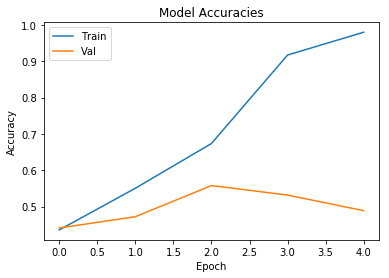

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [14]:
# With stop word removal, demojizing, string.punctuation word remova, vocab size 30000, padding at 50, get 0.56 val accuracy 
# decresing vocab size to 5000 causes bad results and strange effects
# adding dropout 0.1 between embedding and lstm made it worse by 2%

In [15]:
# Load the weights from the model with the best val accuracy
model.load_weights(weightsFilePath)
y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

In [16]:
cm = confusion_matrix(y_val_text, y_pred_text)

In [17]:
# Rows are the actual, columns are the predicted.  negative, neutral, positve
print(cm)
recall1 = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
recall2 = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
recall3 = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(recall1,recall2,recall3)

[[160 124   1]
 [ 69 294   5]
 [ 25 147  14]]
0.5614035087719298 0.7989130434782609 0.07526881720430108


In [18]:
(cm[0][0] + cm[1][1] + cm[2][2])/sum(sum(cm))

0.5578069129916567

## Performance on Test Data


In [19]:
# Load the data
testdf = pd.read_csv('./SemEval2017-task4-test/SemEval2017-task4-test.subtask-A.arabic.txt', sep='\t', header=None, keep_default_na=False)
testdf.columns = ['id','label','raw']

testdf['text'] = testdf.apply(lambda row: preprocess(row['raw'], stop_words),axis=1)
testdf['numSeq'] = testdf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)



In [20]:
x_test = testdf['numSeq']
y_test = testdf['label']

# Prelim analysis to indicate class imbalance
print(y_test.value_counts())

# Onehot encode the y data
y_test = onehot_encoder.transform(np.array(y_test).reshape(len(y_test),1))
x_test = np.array([x for y in x_test for x in y]).reshape(len(x_test),MAXIMUM_LENGTH)

neutral     2363
negative    2221
positive    1514
Name: label, dtype: int64


In [21]:
# Get predictions and prepare data for confusion matrix
y_testpred = model.predict(x_test)
y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_testpred])
y_testpred_text = onehot_encoder.inverse_transform(y_testpred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [23]:
def averageFScore(cm):
    (noClasses,_) = cm.shape
    fsum = 0
    for i in range(noClasses):
        correct = cm[i][i]
        rowTotal = sum(cm[i])
        colTotal = sum(cm[:,i])
        recall = correct / rowTotal
        precision = correct / colTotal
        denominator = precision + recall if precision + recall > 0 else 1
        f1 = 2*precision*recall / denominator
        fsum += f1
    return fsum/noClasses

In [24]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, y_testpred_text, labels=['negative','neutral','positive'])

print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2])/sum(sum(cm))
print(f"Test Accuracy: {testAccuracy}")
recall1 = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
recall2 = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
recall3 = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f"Negative, neutral, positive recall: {recall1},{recall2},{recall3}")
print(f"Average fscore: {averageFScore(cm)}")

[[ 926 1288    7]
 [ 461 1891   11]
 [ 275 1226   13]]
Test Accuracy: 0.46408658576582484
Negative, neutral, positive recall: 0.41692931112111664,0.8002539145154465,0.008586525759577279
Average fscore: 0.3508618122549789


Confusion matrix shows prediction in columns of negative, neutral and positive. Groundtruth are in rows of negative, neutral and positive. 
Test accuracy is 46.4%. We can see from the confusion matrix that the classifier particularly struggles to classify when the text is neutral, its recall of positive samples is 0.85%. Therefore to help improve this model we could try concentrating on features that help to classify positive text. The fact that the model is worse than guessing when the data is positive is concerning and suggests there is a lot of room for improvement. We would expect that the neutral class is the hardest to classify though as it's most similar to the two other classes. Both the training and test data have a class imbalance. Future work could try addressing this class imbalance. I think large difference between the neutral and the positive recalls shows the model struggles to distiguish between them and has placed its decision boundary to get more of the neutral cases right. The positive class si the smallest in both the test and the training data, which may explain why the model has done this. If we wanted to identify neutral tweets then this model would be very useful but most applications would want to classify the negative or the positive tweets, so the future work may want to incentivise the model to improve recall on negative and positive classes, either by balancing the data or creating a custom loss function. 

TODO: Need to check whether i should be running the test data against a model that has been trained on all the training data. If so: Also need to work out how many epochs that model would have to be trained for.

If not: Then i need to run the test data against the training model that has been trained for the number of epochs that gave the highest validation accuracy. 

Should also try using a CNN on the arabic data rather than LSTM because the CNN should require much less data to optimise than the CNN. The lack of arabic data is a real challenge for this model. 